In [27]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=2)

repl = PythonREPL()


In [28]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

    result_str = f"Successfully executed:\n\`\`\`python\n{
        code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15220\347796640.py:13: SyntaxWarning: invalid escape sequence '\`'
  code}\n\`\`\`\nStdout: {result}"
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15220\347796640.py:13: SyntaxWarning: invalid escape sequence '\`'
  code}\n\`\`\`\nStdout: {result}"


In [29]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )


In [30]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from dotenv import load_dotenv
import os

load_dotenv()

GROQ_MODEL = os.getenv("GROQ_MODEL")
GROQ_API = os.getenv("GROQ_API_KEY")
llm = ChatGroq(api_key=GROQ_API, model=GROQ_MODEL)


In [31]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto


In [32]:
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )
)


In [33]:
def research_node(state: MessagesState) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )


In [34]:
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    )
)


In [35]:
def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={

            "messages": result["messages"],
        },
        goto=goto,
    )


In [36]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()


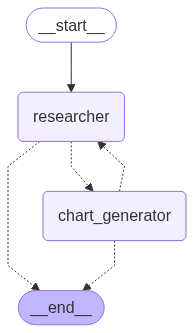

In [37]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [38]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },

    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_calls": [\n\t\t{\n\t\t\t"id": "pending",\n\t\t\t"type": "function",\n\t\t\t"function": {\n\t\t\t\t"name": "get_uk_gdp_data"\n\t\t\t},\n\t\t\t"parameters": {\n\t\t\t\t"start_year": "2017",\n\t\t\t\t"end_year": "2021"\n\t\t\t}\n\t\t},\n\t\t{\n\t\t\t"id": "pending",\n\t\t\t"type": "function",\n\t\t\t"function": {\n\t\t\t\t"name": "create_line_chart"\n\t\t\t},\n\t\t\t"parameters": {\n\t\t\t\t"data": {\n\t\t\t\t\t"x_axis": "Year",\n\t\t\t\t\t"y_axis": "GDP (billions GBP)",\n\t\t\t\t\t"series": [\n\t\t\t\t\t\t{\n\t\t\t\t\t\t\t"name": "UK GDP",\n\t\t\t\t\t\t\t"data": []\n\t\t\t\t\t\t}\n\t\t\t\t\t]\n\t\t\t\t}\n\t\t\t}\n\t\t}\n\t]\n}\n</tool-use>'}}